In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV

### Load the data

In [81]:
df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

### Compute Urea Reduction Rate (URR)

In [82]:
df['URR'] = ((df['BU - pre HD'] - df['BU - post HD']) / df['BU - pre HD']) * 100
df['URR'] = df['URR'].round(3)

# Count how many rows will be removed
removed_count = (df['URR'] < 20).sum()
print(f"Rows with URR < 20: {removed_count}")

# Filter out those rows
df = df[df['URR'] >= 20].copy()

Rows with URR < 20: 6


### Create the Target

In [83]:
df['target'] = (df['URR'] < 65).astype(int)

#### Sort by Subject_ID and Month to maintain chronological order

In [84]:
df = df.sort_values(by=['Subject_ID', 'Month'])

#### Shift the target backward by 1 row for each patient (next month's target)

In [85]:
df['target_next_month'] = df.groupby('Subject_ID')['target'].shift(-1)
df = df.dropna(subset=['target_next_month']) # Drop rows where next month's target is NaN (last row per patient)

In [86]:
# Convert target_next_month to int (it was float due to NaNs from shift)
df['target_next_month'] = df['target_next_month'].astype(int)

In [87]:
counts = df['target_next_month'].value_counts()
print(counts)

target_next_month
0    257
1     94
Name: count, dtype: int64


In [88]:
df.head(2)

,Subject_ID,Month,Albumin (g/L),BU - post HD,BU - pre HD,Hb (g/dL),S Ca (mmol/L),SCR- post HD (µmol/L),SCR- pre HD (µmol/L),Serum K Post-HD (mmol/L),Serum K Pre-HD (mmol/L),Serum Na Pre-HD (mmol/L),UA (mg/dL),URR,target,target_next_month
0,RHD_THP_001,2024-01-01,28.6,0.26,13.50,11.0,2.25,96.91,538.0,2.4,4.30,136.0,392.0,98.074,0,0
1,RHD_THP_001,2024-02-01,37.7,0.38,14.14,13.1,2.23,97.37,513.6,2.9,4.32,136.0,408.0,97.313,0,1


### Define x and y

In [89]:
unique_ids = df['Subject_ID'].unique()

train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = df[df['Subject_ID'].isin(train_ids)]
test_df = df[df['Subject_ID'].isin(test_ids)]

#### Checks for any overlapping Subject_IDs between train and test data.

In [90]:
def check_patient_overlap(train_df, test_df):
    train_ids = set(train_df['Subject_ID'])
    test_ids = set(test_df['Subject_ID'])
    overlapping_ids = train_ids.intersection(test_ids)
    
    if overlapping_ids:
        print("⚠️ Overlapping Subject_IDs found:")
        print(overlapping_ids)
        return True
    else:
        print("✅ No overlapping Subject_IDs.")
        return False

check_patient_overlap(train_df, test_df)

✅ No overlapping Subject_IDs.


False

In [91]:
X_train = train_df.drop( columns=["Subject_ID", "Month", "target", "target_next_month"] )
y_train = train_df["target_next_month"]

X_test = test_df.drop( columns=["Subject_ID", "Month", "target", "target_next_month"] )
y_test = test_df["target_next_month"]

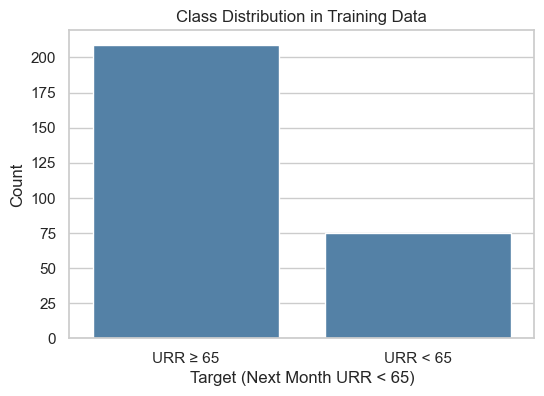

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, color='steelblue')
plt.title("Class Distribution in Training Data")
plt.xlabel("Target (Next Month URR < 65)")
plt.ylabel("Count")
plt.xticks([0, 1], ['URR ≥ 65', 'URR < 65']) 
plt.show()


In [93]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (284, 12) (284,)
Test set shape: (67, 12) (67,)


# Train the ML Model

- 288 training samples
- 11 features
- Binary classification task (URR < 65 as target)

## Random Forest

In [94]:
modelRandomForest = RandomForestClassifiermodelRandomForest = RandomForestClassifier(
    random_state=42,
    n_estimators=200,              # More trees = better generalization
    max_depth=12,                  # Shallower trees generalize better
    min_samples_split=4,
    min_samples_leaf=4,
    class_weight='balanced',
    n_jobs=-1,
    bootstrap=True,
    max_samples=0.8,  # Use 80% of data for each tree to reduce overfitting
    max_features='sqrt',  # Use square root of features for each split
    
)

modelRandomForest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, max_samples=0.8,
                       min_samples_leaf=4, min_samples_split=4,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [95]:
train_accuracy_RandomForest = modelRandomForest.score(X_train, y_train)
test_accuracy_RandomForest = modelRandomForest.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy_RandomForest:.2f}")
print(f"Test Accuracy: {test_accuracy_RandomForest:.2f}")

if train_accuracy_RandomForest > test_accuracy_RandomForest + 0.15:
    print("⚠️ Warning: Model may be overfitting!")
else:
    print("✅ Model generalizes well.")

Training Accuracy: 0.93
Test Accuracy: 0.67
⚠️ Warning: Model may be overfitting!


## XGBoost

In [96]:
modelXGBoost = XGBClassifier( 
    random_state=42,
    scale_pos_weight = 2.63,
    n_estimators=200,  # Number of trees
    max_depth=5,  # Depth of each tree  
    learning_rate=0.01,  # Learning rate
    reg_alpha=3,  # L1 regularization
    reg_lambda=3,  # L2 regularization
    colsample_bytree=1.0,
    subsample=1.0,
    importance_type='gain',
    num_leaves=5,  # Reduced for better generalization
    min_child_samples=10,
    min_child_weight=0.01,
    n_jobs=-1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,  # Avoid warning about label encoder
    tree_method='auto',  # Automatically choose the best tree method
    booster='gbtree',  # Use gradient boosted trees
)

modelXGBoost.fit(X_train, y_train)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [13:42:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_child_samples", "num_leaves", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_samples=10, min_child_weight=0.01, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, ...)

In [97]:
train_accuracy_XGBoost = modelXGBoost.score(X_train, y_train)
test_accuracy_XGBoost = modelXGBoost.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy_XGBoost:.2f}")
print(f"Test Accuracy: {test_accuracy_XGBoost:.2f}")

if train_accuracy_XGBoost > test_accuracy_XGBoost + 0.15:
    print("⚠️ Warning: Model may be overfitting!")
else:
    print("✅ Model generalizes well.")

Training Accuracy: 0.96
Test Accuracy: 0.66
⚠️ Warning: Model may be overfitting!


## LightGBM

In [98]:
modelLightGBM = LGBMClassifier(random_state=42,
                                 reg_alpha=3, reg_lambda=5,
                                 max_depth=5,
                                 n_estimators=10,
                                 boosting_type='gbdt',
                                 class_weight=None,
                                 colsample_bytree=1.0,
                                 subsample=1.0, 
                                 importance_type='gain',
                                 num_leaves=15,
                                 min_child_samples=10,
                                 min_child_weight=0.01,
                                 n_jobs=-1,
                                 objective='binary',
                                 learning_rate=0.1,
                                 )

modelLightGBM.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 75, number of negative: 209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264085 -> initscore=-1.024846
[LightGBM] [Info] Start training from score -1.024846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(importance_type='gain', max_depth=5, min_child_samples=10,
               min_child_weight=0.01, n_estimators=10, n_jobs=-1, num_leaves=15,
               objective='binary', random_state=42, reg_alpha=3, reg_lambda=5)

In [99]:
train_accuracy_LightGBM = modelLightGBM.score(X_train, y_train)
test_accuracy_LightGBM = modelLightGBM.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy_XGBoost:.2f}")
print(f"Test Accuracy: {test_accuracy_XGBoost:.2f}")

if train_accuracy_LightGBM > test_accuracy_LightGBM + 0.15:
    print("⚠️ Warning: Model may be overfitting!")
else:
    print("✅ Model generalizes well.")

Training Accuracy: 0.96
Test Accuracy: 0.66
✅ Model generalizes well.


## BalancedBaggingClassifier with LightGBM

In [100]:
from imblearn.ensemble import BalancedBaggingClassifier

In [101]:
# Create LightGBM base estimator
lgbm_base = LGBMClassifier(
    random_state=42,
    reg_alpha=2, 
    reg_lambda=2,
    max_depth=10,  # Reduced from 100 for bagging
    n_estimators=50,  # Reduced from 500 for bagging
    boosting_type='gbdt',
    class_weight='balanced',
    colsample_bytree=0.8,  # Reduced for more diversity
    subsample=0.8,  # Reduced for more diversity
    importance_type='gain',
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    n_jobs=-1,
    objective='binary',
    learning_rate=0.01,  # Increased from 0.001
    verbose=-1  # Suppress output
)

# Create BalancedBaggingClassifier with LightGBM
modelBalancedBagging = BalancedBaggingClassifier(
    estimator=lgbm_base,  # Changed from base_estimator to estimator
    n_estimators=20,  # Number of base estimators in the ensemble
    random_state=42,
    replacement=False,  # Sample without replacement
    bootstrap_features=False,  # Use all features
    n_jobs=-1
)

modelBalancedBagging.fit(X_train, y_train)

BalancedBaggingClassifier(estimator=LGBMClassifier(class_weight='balanced',
                                                   colsample_bytree=0.8,
                                                   importance_type='gain',
                                                   learning_rate=0.01,
                                                   max_depth=10,
                                                   n_estimators=50, n_jobs=-1,
                                                   objective='binary',
                                                   random_state=42, reg_alpha=2,
                                                   reg_lambda=2, subsample=0.8,
                                                   verbose=-1),
                          n_estimators=20, n_jobs=-1, random_state=42)

In [102]:
train_accuracy_BalancedBagging = modelBalancedBagging.score(X_train, y_train)
test_accuracy_BalancedBagging = modelBalancedBagging.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy_BalancedBagging:.2f}")
print(f"Test Accuracy: {test_accuracy_BalancedBagging:.2f}")

if train_accuracy_BalancedBagging > test_accuracy_BalancedBagging + 0.15:
    print("⚠️ Warning: Model may be overfitting!")
else:
    print("✅ Model generalizes well.")

Training Accuracy: 0.76
Test Accuracy: 0.69
✅ Model generalizes well.


## EasyEnsemble with LightGBM

In [103]:
from imblearn.ensemble import EasyEnsembleClassifier

In [104]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from scipy.stats import randint, uniform

# Define base LGBM (no need to set all params here, they'll be tuned)
base_lgbm = LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, verbose=-1)

# Define parameter grid
param_dist = {
    # EasyEnsemble-level
    'n_estimators': randint(5, 20),
    
    # Base LGBM estimator hyperparameters (prefix with 'estimator__')
    'estimator__n_estimators': randint(20, 100),
    'estimator__learning_rate': uniform(0.005, 0.05),
    'estimator__max_depth': randint(3, 10),
    'estimator__num_leaves': randint(5, 30),
    'estimator__min_child_samples': randint(5, 30),
    'estimator__subsample': uniform(0.6, 0.4),
    'estimator__colsample_bytree': uniform(0.6, 0.4),
    'estimator__reg_alpha': uniform(0, 2),
    'estimator__reg_lambda': uniform(0, 2),
}

# Create EasyEnsemble model with base LGBM
model = EasyEnsembleClassifier(
    estimator=base_lgbm,
    random_state=42,
    replacement=False,
    n_jobs=-1,
    sampling_strategy='auto'
)

# Randomized Search with cross-validation
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=40,
    scoring='f1',  # or 'roc_auc', 'recall' depending on your goal
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

# Run search
search.fit(X_train, y_train)

# Best model
modelEasyEnsemble = search.best_estimator_
print("Best params:", search.best_params_)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'estimator__colsample_bytree': 0.7334834444556088, 'estimator__learning_rate': 0.01214334089609704, 'estimator__max_depth': 5, 'estimator__min_child_samples': 26, 'estimator__n_estimators': 72, 'estimator__num_leaves': 6, 'estimator__reg_alpha': 1.4439975445336495, 'estimator__reg_lambda': 1.8771054180315003, 'estimator__subsample': 0.6003115063364057, 'n_estimators': 16}
Best params: {'estimator__colsample_bytree': 0.7334834444556088, 'estimator__learning_rate': 0.01214334089609704, 'estimator__max_depth': 5, 'estimator__min_child_samples': 26, 'estimator__n_estimators': 72, 'estimator__num_leaves': 6, 'estimator__reg_alpha': 1.4439975445336495, 'estimator__reg_lambda': 1.8771054180315003, 'estimator__subsample': 0.6003115063364057, 'n_estimators': 16}


In [105]:
train_accuracy_EasyEnsemble = modelEasyEnsemble.score(X_train, y_train)
test_accuracy_EasyEnsemble = modelEasyEnsemble.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy_EasyEnsemble:.2f}")
print(f"Test Accuracy: {test_accuracy_EasyEnsemble:.2f}")

if train_accuracy_EasyEnsemble > test_accuracy_EasyEnsemble + 0.15:
    print("⚠️ Warning: Model may be overfitting!")
else:
    print("✅ Model generalizes well.")

Training Accuracy: 0.72
Test Accuracy: 0.67
✅ Model generalizes well.


# Evaluate the Models - Functions

In [106]:
def plot_confusion_matrix(y_true, y_pred, title):
    plt.figure(figsize=(2, 2))  # Reduced size
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                annot_kws={'size': 10}, cbar=False)
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)
    plt.title(title, fontsize=10, pad=10)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            y_probs = model.decision_function(X_test)
        else:
            print(f"Skipping ROC for {name} (no probability or decision function).")
            continue
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            y_probs = model.decision_function(X_test)
        else:
            print(f"Skipping PR curve for {name} (no probability or decision function).")
            continue
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        plt.plot(recall, precision, label=name)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def plot_feature_importance(model, X_train, model_name):
    if hasattr(model, 'feature_importances_'):
        fi = model.feature_importances_
        indices = fi.argsort()[::-1]
        features = X_train.columns

        plt.figure(figsize=(10,6))
        sns.barplot(x=fi[indices], y=features[indices])
        plt.title(f'Feature Importance for {model_name}')
        plt.show()
    else:
        print(f"No feature importance available for {model_name}.")

In [107]:
models = {
    'Random Forest': modelRandomForest,
    'LightGBM': modelLightGBM,
    'BalancedBagging + LightGBM': modelBalancedBagging,
    'EasyEnsemble + LightGBM': modelEasyEnsemble,
}

# Results

In [108]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def tune_threshold_dual_recall(y_true, y_probs, 
                               min_recall_0=0.60, 
                               start_thresh=0.1, 
                               end_thresh=0.9, 
                               steps=20000):
    best_recall_1 = 0
    best_thresh = 0.5

    for thresh in np.linspace(start_thresh, end_thresh, steps):
        y_pred = (y_probs >= thresh).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=None, labels=[0, 1]
        )

        recall_0, recall_1 = recall

        if recall_1 > best_recall_1 and recall_0 >= min_recall_0:
            best_recall_1 = recall_1
            best_thresh = thresh

    return best_thresh, best_recall_1


# Threshold Tuning for All Models

Fine-tuning classification thresholds to optimize performance for each model using the dual recall approach.

In [109]:
# Apply threshold tuning to all models
print("="*100)
print("THRESHOLD TUNING RESULTS")
print("="*100)

tuned_results = []

for name, model in models.items():
    print(f"\nTuning threshold for {name}...")
    
    # Check if model has predict_proba method
    if hasattr(model, 'predict_proba'):
        # Get probability predictions
        y_probs = model.predict_proba(X_test)[:, 1]
        
        # Tune threshold
        best_thresh, best_recall_1 = tune_threshold_dual_recall(
            y_test, y_probs, 
            min_recall_0=0.60,  # Minimum recall for majority class (URR ≥ 65)
            start_thresh=0.1, 
            end_thresh=0.9, 
            steps=1000
        )
        
        # Get predictions with tuned threshold
        y_pred_tuned = (y_probs >= best_thresh).astype(int)
        
        # Calculate metrics with tuned threshold
        from sklearn.metrics import precision_recall_fscore_support
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred_tuned, average=None, labels=[0, 1]
        )
        
        # Calculate overall accuracy
        accuracy = (y_pred_tuned == y_test).mean()
        
        # Store results
        tuned_results.append({
            'Model': name,
            'Optimal Threshold': f"{best_thresh:.3f}",
            'Accuracy': f"{accuracy:.3f}",
            'Recall (URR ≥ 65)': f"{recall[0]:.3f}",
            'Recall (URR < 65)': f"{recall[1]:.3f}",
            'Precision (URR ≥ 65)': f"{precision[0]:.3f}",
            'Precision (URR < 65)': f"{precision[1]:.3f}",
            'F1 (URR ≥ 65)': f"{f1[0]:.3f}",
            'F1 (URR < 65)': f"{f1[1]:.3f}"
        })
        
        print(f"  ✅ Optimal threshold: {best_thresh:.3f}")
        print(f"  📈 Recall for URR < 65: {recall[1]:.3f}")
        print(f"  📈 Recall for URR ≥ 65: {recall[0]:.3f}")
        
    else:
        print(f"  ⚠️ {name} does not support probability predictions - skipping threshold tuning")

# Display results in a table
tuned_df = pd.DataFrame(tuned_results)
print(f"\n{'='*100}")
print("THRESHOLD TUNING SUMMARY TABLE")
print(f"{'='*100}")
print(tuned_df.to_string(index=False))
print(f"{'='*100}")
print("Notes:")
print("- Threshold tuning optimizes for maximum recall of URR < 65 while maintaining ≥60% recall for URR ≥ 65")
print("- This ensures we don't miss too many patients who need adequate URR")
print("- Lower thresholds tend to increase sensitivity (recall) for the minority class")
print(f"{'='*100}")

THRESHOLD TUNING RESULTS

Tuning threshold for Random Forest...


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

  ✅ Optimal threshold: 0.323
  📈 Recall for URR < 65: 0.684
  📈 Recall for URR ≥ 65: 0.604

Tuning threshold for LightGBM...


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

  ✅ Optimal threshold: 0.227
  📈 Recall for URR < 65: 0.737
  📈 Recall for URR ≥ 65: 0.604

Tuning threshold for BalancedBagging + LightGBM...


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

  ✅ Optimal threshold: 0.480
  📈 Recall for URR < 65: 0.632
  📈 Recall for URR ≥ 65: 0.604

Tuning threshold for EasyEnsemble + LightGBM...


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

  ✅ Optimal threshold: 0.476
  📈 Recall for URR < 65: 0.684
  📈 Recall for URR ≥ 65: 0.604

THRESHOLD TUNING SUMMARY TABLE
                     Model Optimal Threshold Accuracy Recall (URR ≥ 65) Recall (URR < 65) Precision (URR ≥ 65) Precision (URR < 65) F1 (URR ≥ 65) F1 (URR < 65)
             Random Forest             0.323    0.627             0.604             0.684                0.829                0.406         0.699         0.510
                  LightGBM             0.227    0.642             0.604             0.737                0.853                0.424         0.707         0.538
BalancedBagging + LightGBM             0.480    0.612             0.604             0.632                0.806                0.387         0.690         0.480
   EasyEnsemble + LightGBM             0.476    0.627             0.604             0.684                0.829                0.406         0.699         0.510
Notes:
- Threshold tuning optimizes for maximum recall of URR < 65 while main

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Before vs After Threshold Tuning Comparison

In [110]:
# Create comparison between default threshold (0.5) and optimized threshold
comparison_data = []

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_probs = model.predict_proba(X_test)[:, 1]
        
        # Default threshold (0.5) predictions
        y_pred_default = (y_probs >= 0.5).astype(int)
        
        # Find the optimized threshold from our tuned results
        tuned_row = tuned_df[tuned_df['Model'] == name]
        if not tuned_row.empty:
            optimal_thresh = float(tuned_row['Optimal Threshold'].iloc[0])
            y_pred_tuned = (y_probs >= optimal_thresh).astype(int)
            
            # Calculate metrics for both
            from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
            
            # Default threshold metrics
            default_acc = accuracy_score(y_test, y_pred_default)
            default_precision_1 = precision_score(y_test, y_pred_default, pos_label=1, zero_division=0)
            default_recall_1 = recall_score(y_test, y_pred_default, pos_label=1, zero_division=0)
            default_f1_1 = f1_score(y_test, y_pred_default, pos_label=1, zero_division=0)
            
            # Tuned threshold metrics
            tuned_acc = accuracy_score(y_test, y_pred_tuned)
            tuned_precision_1 = precision_score(y_test, y_pred_tuned, pos_label=1, zero_division=0)
            tuned_recall_1 = recall_score(y_test, y_pred_tuned, pos_label=1, zero_division=0)
            tuned_f1_1 = f1_score(y_test, y_pred_tuned, pos_label=1, zero_division=0)
            
            # Calculate improvements
            recall_improvement = tuned_recall_1 - default_recall_1
            f1_improvement = tuned_f1_1 - default_f1_1
            
            comparison_data.append({
                'Model': name,
                'Default Threshold': '0.500',
                'Optimal Threshold': f"{optimal_thresh:.3f}",
                'Default Recall (URR<65)': f"{default_recall_1:.3f}",
                'Tuned Recall (URR<65)': f"{tuned_recall_1:.3f}",
                'Recall Improvement': f"{recall_improvement:+.3f}",
                'Default F1 (URR<65)': f"{default_f1_1:.3f}",
                'Tuned F1 (URR<65)': f"{tuned_f1_1:.3f}",
                'F1 Improvement': f"{f1_improvement:+.3f}"
            })

# Display comparison table
comparison_df = pd.DataFrame(comparison_data)
print("="*120)
print("BEFORE vs AFTER THRESHOLD TUNING COMPARISON")
print("="*120)
print(comparison_df.to_string(index=False))
print("="*120)
print("Key Insights:")
print("- Positive improvements indicate better performance after threshold tuning")
print("- Focus on 'Recall Improvement' for URR<65 class (minority class detection)")
print("- Threshold tuning trades off precision for recall to catch more at-risk patients")
print("="*120)

BEFORE vs AFTER THRESHOLD TUNING COMPARISON
                     Model Default Threshold Optimal Threshold Default Recall (URR<65) Tuned Recall (URR<65) Recall Improvement Default F1 (URR<65) Tuned F1 (URR<65) F1 Improvement
             Random Forest             0.500             0.323                   0.211                 0.684             +0.474               0.267             0.510         +0.243
                  LightGBM             0.500             0.227                   0.000                 0.737             +0.737               0.000             0.538         +0.538
BalancedBagging + LightGBM             0.500             0.480                   0.526                 0.632             +0.105               0.488             0.471         -0.017
   EasyEnsemble + LightGBM             0.500             0.476                   0.579                 0.684             +0.105               0.500             0.510         +0.010
Key Insights:
- Positive improvements indicate bett

CONFUSION MATRICES (Using Optimized Thresholds)
Model: Random Forest
Using optimized threshold: 0.323


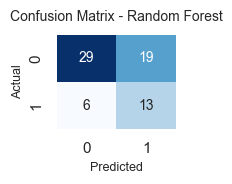

Model: LightGBM
Using optimized threshold: 0.227


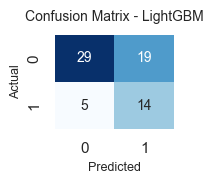

Model: BalancedBagging + LightGBM
Using optimized threshold: 0.480
Using optimized threshold: 0.480


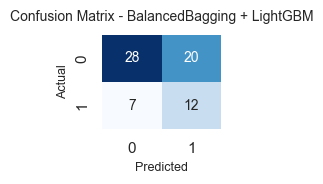

Model: EasyEnsemble + LightGBM
Using optimized threshold: 0.476


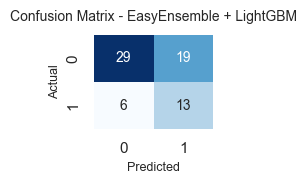

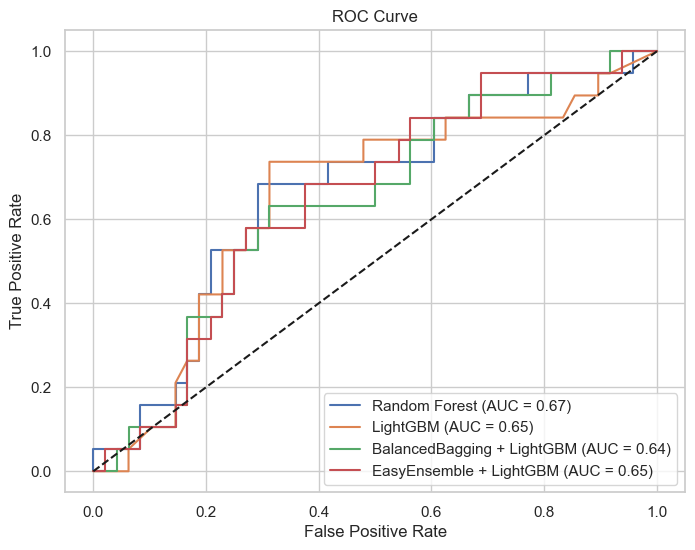

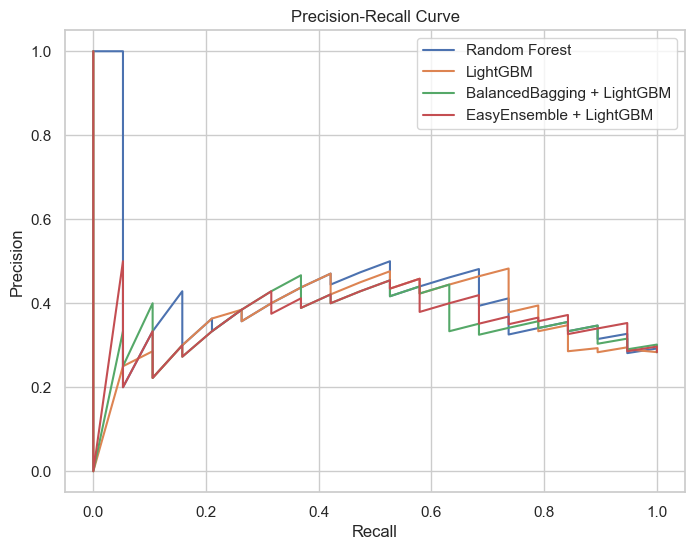

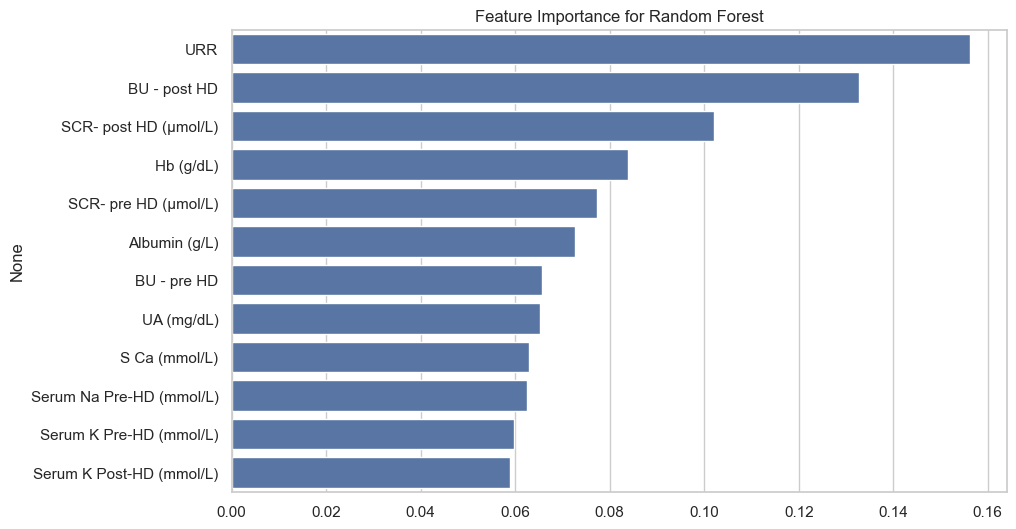

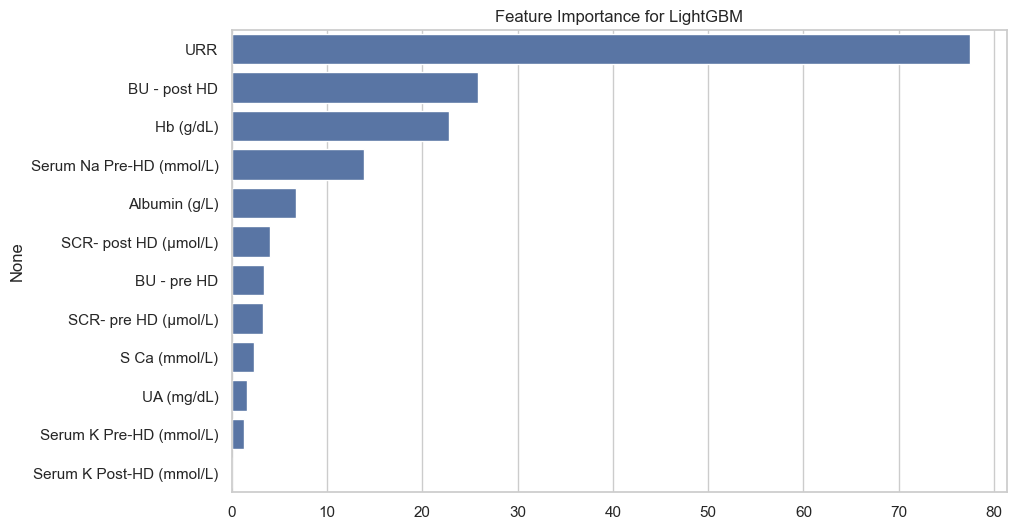

No feature importance available for BalancedBagging + LightGBM.
No feature importance available for EasyEnsemble + LightGBM.


In [111]:
# Plot confusion matrices using OPTIMIZED THRESHOLDS
print("CONFUSION MATRICES (Using Optimized Thresholds)")
print("="*60)

for name, model in models.items():
    print(f"Model: {name}")
    
    # Check if we have optimized threshold for this model
    tuned_row = tuned_df[tuned_df['Model'] == name]
    if not tuned_row.empty and hasattr(model, 'predict_proba'):
        # Use optimized threshold
        optimal_thresh = float(tuned_row['Optimal Threshold'].iloc[0])
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= optimal_thresh).astype(int)
        print(f"Using optimized threshold: {optimal_thresh:.3f}")
    else:
        # Fall back to default prediction
        y_pred = model.predict(X_test)
        print("Using default threshold: 0.500")
    
    plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix - {name}')

# Plot ROC curves
plot_roc_curve(models, X_test, y_test)

# Plot Precision-Recall curves
plot_precision_recall_curve(models, X_test, y_test)

# Plot feature importance for tree-based models
for name, model in models.items():
    plot_feature_importance(model, X_train, name)

# Classification Reports

Detailed performance metrics for each model including precision, recall, F1-score, and support.

In [112]:
# Generate classification reports for all models using OPTIMIZED THRESHOLDS
print("="*80)
print("CLASSIFICATION REPORTS FOR ALL MODELS (Using Optimized Thresholds)")
print("="*80)

target_names = ['URR ≥ 65', 'URR < 65']  # Class names for better readability

for name, model in models.items():
    print(f"\n{'-'*60}")
    print(f"Model: {name}")
    print(f"{'-'*60}")
    
    # Check if we have optimized threshold for this model
    tuned_row = tuned_df[tuned_df['Model'] == name]
    if not tuned_row.empty and hasattr(model, 'predict_proba'):
        # Use optimized threshold
        optimal_thresh = float(tuned_row['Optimal Threshold'].iloc[0])
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= optimal_thresh).astype(int)
        print(f"Using optimized threshold: {optimal_thresh:.3f}")
        
        # Calculate ROC AUC with probabilities
        roc_auc = roc_auc_score(y_test, y_probs)
    else:
        # Fall back to default prediction
        y_pred = model.predict(X_test)
        print("Using default threshold: 0.500")
        
        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=target_names, digits=3)
    print(report)
    
    print(f"ROC AUC Score: {roc_auc:.3f}")
    
print("="*80)

CLASSIFICATION REPORTS FOR ALL MODELS (Using Optimized Thresholds)

------------------------------------------------------------
Model: Random Forest
------------------------------------------------------------
Using optimized threshold: 0.323
              precision    recall  f1-score   support

    URR ≥ 65      0.829     0.604     0.699        48
    URR < 65      0.406     0.684     0.510        19

    accuracy                          0.627        67
   macro avg      0.617     0.644     0.604        67
weighted avg      0.709     0.627     0.645        67

ROC AUC Score: 0.666

------------------------------------------------------------
Model: LightGBM
------------------------------------------------------------
Using optimized threshold: 0.227
              precision    recall  f1-score   support

    URR ≥ 65      0.853     0.604     0.707        48
    URR < 65      0.424     0.737     0.538        19

    accuracy                          0.642        67
   macro avg      

# Model Comparison Summary

A comprehensive comparison of all models with key performance metrics.

In [113]:
# Create comprehensive model comparison table
from sklearn.metrics import precision_score, recall_score, f1_score

results_data = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Precision, Recall, F1 for minority class (URR < 65, class 1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    # ROC AUC
    try:
        if hasattr(model, 'predict_proba'):
            roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_pred)
    except:
        roc_auc = 0.0
    
    results_data.append({
        'Model': name,
        'Train Accuracy': f"{train_acc:.3f}",
        'Test Accuracy': f"{test_acc:.3f}",
        'Precision (URR<65)': f"{precision:.3f}",
        'Recall (URR<65)': f"{recall:.3f}",
        'F1-Score (URR<65)': f"{f1:.3f}",
        'ROC AUC': f"{roc_auc:.3f}",
        'Overfitting': "Yes" if (train_acc - test_acc) > 0.15 else "No"
    })

# Convert to DataFrame for better display
results_df = pd.DataFrame(results_data)

print("="*120)
print("MODEL COMPARISON SUMMARY")
print("="*120)
print()
print(results_df.to_string(index=False))
print()
print("="*120)
print("Notes:")
print("- Precision (URR<65): Of all predicted URR<65 cases, how many were actually URR<65")
print("- Recall (URR<65): Of all actual URR<65 cases, how many were correctly identified")
print("- F1-Score (URR<65): Harmonic mean of precision and recall for URR<65 class")
print("- ROC AUC: Area Under the ROC Curve (higher is better)")
print("- Overfitting: Train accuracy > Test accuracy by more than 15%")
print("="*120)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MODEL COMPARISON SUMMARY

                     Model Train Accuracy Test Accuracy Precision (URR<65) Recall (URR<65) F1-Score (URR<65) ROC AUC Overfitting
             Random Forest          0.926         0.672              0.364           0.211             0.267   0.666         Yes
                  LightGBM          0.736         0.716              0.000           0.000             0.000   0.651          No
BalancedBagging + LightGBM          0.761         0.687              0.455           0.526             0.488   0.638          No
   EasyEnsemble + LightGBM          0.722         0.672              0.440           0.579             0.500   0.651          No

Notes:
- Precision (URR<65): Of all predicted URR<65 cases, how many were actually URR<65
- Recall (URR<65): Of all actual URR<65 cases, how many were correctly identified
- F1-Score (URR<65): Harmonic mean of precision and recall for URR<65 class
- ROC AUC: Area Under the ROC Curve (higher is better)
- Overfitting: Train accu

# Comprehensive Model Performance Comparison

Complete comparison table with all performance metrics using optimized thresholds.

In [114]:
# Create comprehensive model comparison table with all requested metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize list to store comprehensive results
comprehensive_results = []

for name, model in models.items():
    print(f"Processing {name}...")
    
    # Check if we have optimized threshold for this model
    tuned_row = tuned_df[tuned_df['Model'] == name]
    if not tuned_row.empty and hasattr(model, 'predict_proba'):
        # Use optimized threshold
        optimal_thresh = float(tuned_row['Optimal Threshold'].iloc[0])
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= optimal_thresh).astype(int)
        threshold_used = f"{optimal_thresh:.3f}"
    else:
        # Fall back to default prediction
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        threshold_used = "0.500"
    
    # Calculate all metrics
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Macro-averaged metrics
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # ROC AUC
    if y_probs is not None:
        roc_auc = roc_auc_score(y_test, y_probs)
    else:
        roc_auc = 0.0
    
    # Class-specific recalls
    recall_class_specific = recall_score(y_test, y_pred, average=None, zero_division=0)
    recall_class_0 = recall_class_specific[0]  # URR ≥ 65
    recall_class_1 = recall_class_specific[1]  # URR < 65
    
    # Store results
    comprehensive_results.append({
        'Model': name,
        'Threshold': threshold_used,
        'Accuracy': f"{accuracy:.3f}",
        'Precision (Macro)': f"{precision_macro:.3f}",
        'Recall (Macro)': f"{recall_macro:.3f}",
        'F1 (Macro)': f"{f1_macro:.3f}",
        'ROC-AUC': f"{roc_auc:.3f}",
        'Recall (Class 0)': f"{recall_class_0:.3f}",  # URR ≥ 65
        'Recall (Class 1)': f"{recall_class_1:.3f}"   # URR < 65
    })

# Create DataFrame
comprehensive_df = pd.DataFrame(comprehensive_results)

# Display the table
print("\n" + "="*130)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON (Using Optimized Thresholds)")
print("="*130)
print()
print(comprehensive_df.to_string(index=False))
print()
print("="*130)
print("Legend:")
print("- Class 0: URR ≥ 65 (Adequate dialysis efficiency)")
print("- Class 1: URR < 65 (Inadequate dialysis efficiency - needs attention)")
print("- Macro averages: Unweighted mean of the per-class metrics")
print("- Threshold: Classification threshold used (optimized for better minority class detection)")
print("="*130)

Processing Random Forest...
Processing LightGBM...
Processing BalancedBagging + LightGBM...
Processing EasyEnsemble + LightGBM...
Processing LightGBM...
Processing BalancedBagging + LightGBM...
Processing EasyEnsemble + LightGBM...

COMPREHENSIVE MODEL PERFORMANCE COMPARISON (Using Optimized Thresholds)

                     Model Threshold Accuracy Precision (Macro) Recall (Macro) F1 (Macro) ROC-AUC Recall (Class 0) Recall (Class 1)
             Random Forest     0.323    0.627             0.617          0.644      0.604   0.666            0.604            0.684
                  LightGBM     0.227    0.642             0.639          0.671      0.623   0.651            0.604            0.737
BalancedBagging + LightGBM     0.480    0.597             0.588          0.607      0.573   0.638            0.583            0.632
   EasyEnsemble + LightGBM     0.476    0.627             0.617          0.644      0.604   0.651            0.604            0.684

Legend:
- Class 0: URR ≥ 65 (Adeq

In [115]:
# Add Random Forest back to models dictionary for complete comparison
complete_models = {
    'Random Forest': modelRandomForest,
    'LightGBM': modelLightGBM,
    'BalancedBagging + LightGBM': modelBalancedBagging,
    'EasyEnsemble + LightGBM': modelEasyEnsemble,
}

# Create comprehensive model comparison table with ALL models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize list to store comprehensive results
complete_results = []

for name, model in complete_models.items():
    print(f"Processing {name}...")
    
    # Check if we have optimized threshold for this model
    tuned_row = tuned_df[tuned_df['Model'] == name]
    if not tuned_row.empty and hasattr(model, 'predict_proba'):
        # Use optimized threshold
        optimal_thresh = float(tuned_row['Optimal Threshold'].iloc[0])
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= optimal_thresh).astype(int)
        threshold_used = f"{optimal_thresh:.3f}"
    else:
        # Fall back to default prediction
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        threshold_used = "0.500"
    
    # Calculate all metrics
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Macro-averaged metrics
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # ROC AUC
    if y_probs is not None:
        roc_auc = roc_auc_score(y_test, y_probs)
    else:
        roc_auc = 0.0
    
    # Class-specific recalls
    recall_class_specific = recall_score(y_test, y_pred, average=None, zero_division=0)
    recall_class_0 = recall_class_specific[0]  # URR ≥ 65
    recall_class_1 = recall_class_specific[1]  # URR < 65
    
    # Store results
    complete_results.append({
        'Model': name,
        'Threshold': threshold_used,
        'Accuracy': f"{accuracy:.3f}",
        'Precision (Macro)': f"{precision_macro:.3f}",
        'Recall (Macro)': f"{recall_macro:.3f}",
        'F1 (Macro)': f"{f1_macro:.3f}",
        'ROC-AUC': f"{roc_auc:.3f}",
        'Recall (Class 0)': f"{recall_class_0:.3f}",  # URR ≥ 65
        'Recall (Class 1)': f"{recall_class_1:.3f}"   # URR < 65
    })

# Create DataFrame
complete_comparison_df = pd.DataFrame(complete_results)

# Display the table
print("\n" + "="*140)
print("COMPLETE MODEL PERFORMANCE COMPARISON (Using Optimized Thresholds)")
print("="*140)
print()
print(complete_comparison_df.to_string(index=False))
print()
print("="*140)
print("Performance Insights:")
print("• Higher Recall (Class 1) = Better at detecting patients with inadequate URR (< 65%)")
print("• Higher Recall (Class 0) = Better at correctly identifying patients with adequate URR (≥ 65%)")
print("• Macro averages give equal weight to both classes (balanced view)")
print("• ROC-AUC measures overall discrimination ability")
print("• Optimized thresholds improve minority class (URR < 65) detection")
print("="*140)

Processing Random Forest...
Processing LightGBM...
Processing BalancedBagging + LightGBM...
Processing EasyEnsemble + LightGBM...

COMPLETE MODEL PERFORMANCE COMPARISON (Using Optimized Thresholds)

                     Model Threshold Accuracy Precision (Macro) Recall (Macro) F1 (Macro) ROC-AUC Recall (Class 0) Recall (Class 1)
             Random Forest     0.323    0.627             0.617          0.644      0.604   0.666            0.604            0.684
                  LightGBM     0.227    0.642             0.639          0.671      0.623   0.651            0.604            0.737
BalancedBagging + LightGBM     0.480    0.597             0.588          0.607      0.573   0.638            0.583            0.632
   EasyEnsemble + LightGBM     0.476    0.627             0.617          0.644      0.604   0.651            0.604            0.684

Performance Insights:
• Higher Recall (Class 1) = Better at detecting patients with inadequate URR (< 65%)
• Higher Recall (Class 0) = Bette